In [42]:
import bs4 as bs
import pandas as pd
import requests



b_parameters = {
    "B_1": "D76.V1-level1", # Year
    "B_2": "D76.V1-level2", # Month
    "B_3": "D76.V2-level3 ",# Cause of death
    "B_4": "*None*",
    "B_5": "*None*"
}

m_parameters = {
    "M_1": "D76.M1",
    "M_2": "D76.M2",
    "M_3": "D76.M3",
    "M_41": "D76.M41",
    "M_42": "D76.M42"
}

f_parameters = {
    "F_D76.V1": ["*All*"],
    "F_D76.V10": ["*All*"], # Code for influenza and pneumonia seperated, J09-J11 is influenza, and pneumonia is J12-J18
    "F_D76.V2": ["J09-J18"],
    #"F_D76.V2": ["K00-K92"],
    "F_D76.V27": ["*All*"],
    "F_D76.V9": ["*All*"]
}

i_parameters = {
    "I_D76.V1": "*All* (All Dates)",  # year/month
    "I_D76.V10": "*All* (The United States)", # Census Regions - dont change
    "I_D76.V27": "*All* (The United States)", # HHS Regions - dont change
    "I_D76.V9": "*All* (The United States)" # State County - dont change
}

v_parameters = {
    "V_D76.V1": "",         
    "V_D76.V10": "",        
    "V_D76.V11": "*All*",   
    "V_D76.V12": "*All*",   
    "V_D76.V17": "*All*",   
    "V_D76.V19": "*All*",   
    "V_D76.V2": "",         
    "V_D76.V20": "*All*",   
    "V_D76.V21": "*All*",   
    "V_D76.V22": "*All*",   
    "V_D76.V23": "*All*",   
    "V_D76.V24": "*All*",  
    "V_D76.V25": "*All*",   
    "V_D76.V27": "",        
    "V_D76.V4": "*All*",    
    "V_D76.V5": ["15-24", "25-34", "35-44","45-54","55-64","65-74","75-84"],
    "V_D76.V51": "*All*",   
    "V_D76.V52": "*All*",   
    "V_D76.V6": "00",       
    "V_D76.V7": "*All*",   
    "V_D76.V8": "*All*",    
    "V_D76.V9": ""          
}

o_parameters = {
    "O_V10_fmode": "freg",    
    "O_V1_fmode": "freg",     
    "O_V27_fmode": "freg",    
    "O_V2_fmode": "freg",     
    "O_V9_fmode": "freg",     
    "O_aar": "aar_std",
    "O_aar_pop": "0000",
    "O_age": "D76.V5",
    "O_javascript": "on",
    "O_location": "D76.V9",
    "O_precision": "1",
    "O_rate_per": "100000",
    "O_show_totals": "false",
    "O_timeout": "300",
    "O_title": "Digestive Disease Deaths, by Age Group",
    "O_ucd": "D76.V2",
    "O_urban": "D76.V19"
}

vm_parameters = {
    "VM_D76.M6_D76.V10": "",
    "VM_D76.M6_D76.V17": "*All*",
    "VM_D76.M6_D76.V1_S": "*All*",
    "VM_D76.M6_D76.V7": "*All*",
    "VM_D76.M6_D76.V8": "*All*"
}

misc_parameters = {
    "action-Send": "Send",
    "finder-stage-D76.V1": "codeset",
    "finder-stage-D76.V1": "codeset",
    "finder-stage-D76.V2": "codeset",
    "finder-stage-D76.V27": "codeset",
    "finder-stage-D76.V9": "codeset",
    "stage": "request"
}

if __name__ == '__main__':

    def createParameterList(parameterList):
        """Helper function to create a parameter list from a dictionary object"""

        parameterString = ""

        for key in parameterList:
            parameterString += "<parameter>\n"
            parameterString += "<name>" + key + "</name>\n"

            if isinstance(parameterList[key], list):
                for value in parameterList[key]:
                    parameterString += "<value>" + value + "</value>\n"
            else:
                parameterString += "<value>" + parameterList[key] + "</value>\n"

            parameterString += "</parameter>\n"

        return parameterString

    xml_request = "<request-parameters>\n"
    xml_request += createParameterList(b_parameters)
    xml_request += createParameterList(m_parameters)
    xml_request += createParameterList(f_parameters)
    xml_request += createParameterList(i_parameters)
    xml_request += createParameterList(o_parameters)
    xml_request += createParameterList(vm_parameters)
    xml_request += createParameterList(v_parameters)
    xml_request += createParameterList(misc_parameters)
    xml_request += "</request-parameters>"

    url = "https://wonder.cdc.gov/controller/datarequest/D76"
    response = requests.post(url, data={"request_xml": xml_request, "accept_datause_restrictions": "true"})

    if response.status_code == 200:
        data = response.text
    else:
        print("something went wrong")


    def xml2df(xml_data):
        root = bs.BeautifulSoup(xml_data, "lxml")
        all_records = []
        row_number = 0
        rows = root.find_all("r")

        for row in rows:
            if row_number >= len(all_records):
                all_records.append([])

            for cell in row.find_all("c"):
                if 'v' in cell.attrs:
                    try:
                        all_records[row_number].append(float(cell.attrs["v"].replace(',', '')))
                    except ValueError:
                        all_records[row_number].append(cell.attrs["v"])
                else:
                    if 'r' not in cell.attrs:
                        all_records[row_number].append(cell.attrs["l"])
                    else:

                        for row_index in range(int(cell.attrs["r"])):
                            if (row_number + row_index) >= len(all_records):
                                all_records.append([])
                                all_records[row_number + row_index].append(cell.attrs["l"])
                            else:
                                all_records[row_number + row_index].append(cell.attrs["l"])

            row_number += 1
        return all_records


    data_frame = xml2df(data)
    print(data_frame)

    data_frame = xml2df(data)

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    flu_df = pd.DataFrame(data=data_frame, columns=["Year", "Month", "Cause of Death", "Deaths", "Population", "Crude Rate", "Age-adjusted Rate", "Age-adjusted Rate Standard Error"])
    flu_df.drop(["Population", "Crude Rate", "Age-adjusted Rate", "Age-adjusted Rate Standard Error"],axis=1) # Dropping these, because they contain no data
    flu_df.head()


[['1999', 'Jan., 1999', 'Influenza with pneumonia, influenza virus identified', 1.0, 'Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable'], ['1999', 'Jan., 1999', 'Influenza with other respiratory manifestations, influenza virus identified', 1.0, 'Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable'], ['1999', 'Jan., 1999', 'Influenza with pneumonia, virus not identified', 24.0, 'Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable'], ['1999', 'Jan., 1999', 'Influenza with other respiratory manifestations, virus not identified', 36.0, 'Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable'], ['1999', 'Jan., 1999', 'Influenza with other manifestations, virus not identified', 2.0, 'Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable'], ['1999', 'Jan., 1999', 'Respiratory syncytial virus pneumonia', 1.0, 'Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable'], ['1999', 'Jan., 1999', 'Viral p

Alright, so now that we have data in let's do something with it.

In [43]:
fdym = flu_df.groupby(by=['Year','Month'], as_index = False).sum()

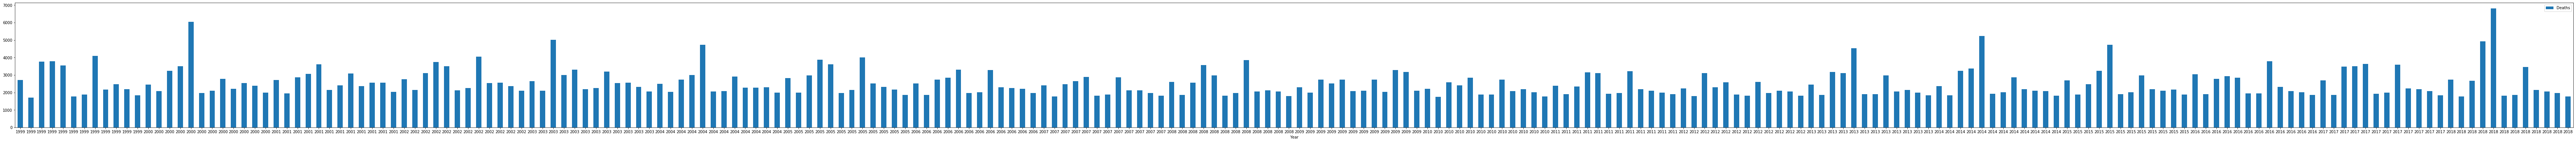

In [46]:
ax = fdym.plot.bar(x='Year', y='Deaths', rot=0, figsize=(120,6))

So that gives a nice aview of the number of deaths in a year, but that doesn't really tell us much other than people died.  Not a death or hospitalization rate or anything.  Thankfully we have other data sources for that to help augment this view.

In [27]:
import glob

path = r'C:\flu_data'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

inf_df = pd.concat(li, axis=0, ignore_index=True)

In [31]:
inf_df.fillna(0,inplace=True)

In [40]:
inf_df['ALL TYPES'] = inf_df.loc['A (2009 H1N1)':'H3N2v'].sum()+inf_df.loc['H1N1':'BYam'].sum()

In [41]:
inf_df

,REGION TYPE,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,REGION,TOTAL A,TOTAL B,PERCENT A,PERCENT B,H1N1,H3,A_no_subtype,BVic,BYam,ALL TYPES
0,National,1997,40,1291.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
1,National,1997,41,1513.0,0.727032,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
2,National,1997,42,1552.0,1.095360,0.0,0.0,3.0,13.0,0.0,1.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
3,National,1997,43,1669.0,0.419413,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
4,National,1997,44,1897.0,0.527148,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
5,National,1997,45,2106.0,0.284900,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
6,National,1997,46,2204.0,0.362976,0.0,0.0,3.0,4.0,0.0,1.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
7,National,1997,47,2533.0,0.908014,0.0,0.0,5.0,17.0,0.0,1.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
8,National,1997,48,2242.0,1.650310,0.0,0.0,14.0,22.0,0.0,1.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
9,National,1997,49,2607.0,1.534330,0.0,0.0,11.0,28.0,0.0,1.0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN
